# HR Analytics - Analyse des causes de démission

## Objectif
Identifier les causes racines du turnover élevé chez TechNova Partners et proposer des leviers d'action.

## 1. Chargement et Inspection des Données

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [7]:
# Chargement des fichiers
df_sirh = pd.read_csv('extrait_sirh.csv')
df_eval = pd.read_csv('extrait_eval.csv')
df_sondage = pd.read_csv('extrait_sondage.csv')

print("Dimensions SIRH:", df_sirh.shape)
print("Dimensions Eval:", df_eval.shape)
print("Dimensions Sondage:", df_sondage.shape)

Dimensions SIRH: (1470, 12)
Dimensions Eval: (1470, 10)
Dimensions Sondage: (1470, 12)


## 2. Nettoyage et Fusion des Données

Nous devons uniformiser les clés de jointure :
- `df_sirh` : `id_employee` est déjà un entier.
- `df_eval` : `eval_number` est sous la forme "E_XXX", nous devons extraire le nombre.
- `df_sondage` : `code_sondage` doit être converti en entier.

In [8]:
# Nettoyage des clés

# 1. SIRH : Renommer pour avoir une clé commune 'id'
df_sirh = df_sirh.rename(columns={'id_employee': 'id'})

# 2. Eval : Nettoyer 'eval_number' (ex: 'E_1' -> 1)
df_eval['id'] = df_eval['eval_number'].astype(str).str.replace('E_', '').astype(int)

# 3. Sondage : Renommer et s'assurer que c'est un int
df_sondage = df_sondage.rename(columns={'code_sondage': 'id'})
df_sondage['id'] = pd.to_numeric(df_sondage['id'], errors='coerce').astype('Int64')

# Vérification des doublons de clés
print("Doublons ID SIRH:", df_sirh['id'].duplicated().sum())
print("Doublons ID Eval:", df_eval['id'].duplicated().sum())
print("Doublons ID Sondage:", df_sondage['id'].duplicated().sum())

Doublons ID SIRH: 0
Doublons ID Eval: 0
Doublons ID Sondage: 0


In [9]:
# Fusion des dataframes
# On utilise un inner join pour ne garder que les employés présents dans les 3 bases
df_merged = df_sirh.merge(df_eval, on='id', how='inner')
df_merged = df_merged.merge(df_sondage, on='id', how='inner')

print("Dimensions après fusion:", df_merged.shape)
df_merged.head()

Dimensions après fusion: (1470, 33)


,id,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,Oui,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,Non,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,Oui,0,3,1,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,Non,0,3,1,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,Non,1,3,1,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [10]:
# Vérification des valeurs manquantes après fusion
df_merged.isnull().sum()[df_merged.isnull().sum() > 0]

Series([], dtype: int64)

## 3. Analyse Exploratoire (EDA)
### 3.1 Analyse de la variable cible (Démission)

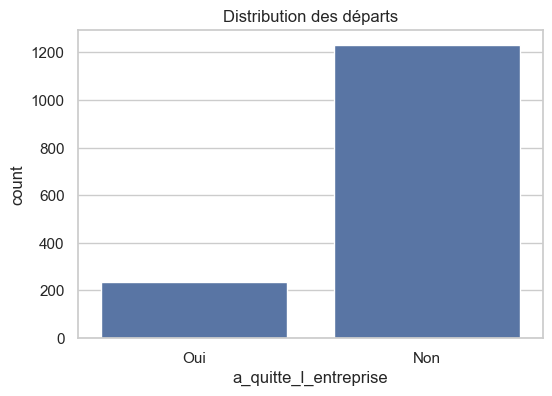

a_quitte_l_entreprise
Non    0.838776
Oui    0.161224
Name: proportion, dtype: float64


In [11]:
target_col = 'a_quitte_l_entreprise'

plt.figure(figsize=(6, 4))
sns.countplot(data=df_merged, x=target_col)
plt.title("Distribution des départs")
plt.show()

print(df_merged[target_col].value_counts(normalize=True))

### 3.2 Statistiques Descriptives

In [12]:
# Séparation des variables numériques et catégorielles
num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_merged.select_dtypes(include=['object']).columns.tolist()

# Retirer 'id' des variables numériques
if 'id' in num_cols:
    num_cols.remove('id')

print("Variables numériques:", len(num_cols))
print("Variables catégorielles:", len(cat_cols))

# Statistiques descriptives pour les numériques
df_merged[num_cols].describe()

Variables numériques: 21
Variables catégorielles: 11


,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252,2.721769,2.729932,2.063946,2.728571,2.712245,2.761224,3.153741,0.793878,2.799320,1.0,9.192517,2.912925,2.187755,4.123129
std,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137,1.093082,0.711561,1.106940,1.102846,1.081209,0.706476,0.360824,0.852077,1.289271,0.0,8.106864,1.024165,3.222430,3.568136
min,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000
25%,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,0.000000,2.000000,1.0,2.000000,2.000000,0.000000,2.000000
50%,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,1.0,7.000000,3.000000,1.000000,3.000000
75%,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,3.000000,1.0,14.000000,4.000000,3.000000,7.000000
max,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,3.000000,6.000000,1.0,29.000000,5.000000,15.000000,17.000000


### 3.3 Analyse des variables numériques vs Démission
Comparons les distributions des variables numériques pour ceux qui sont partis vs ceux qui sont restés.

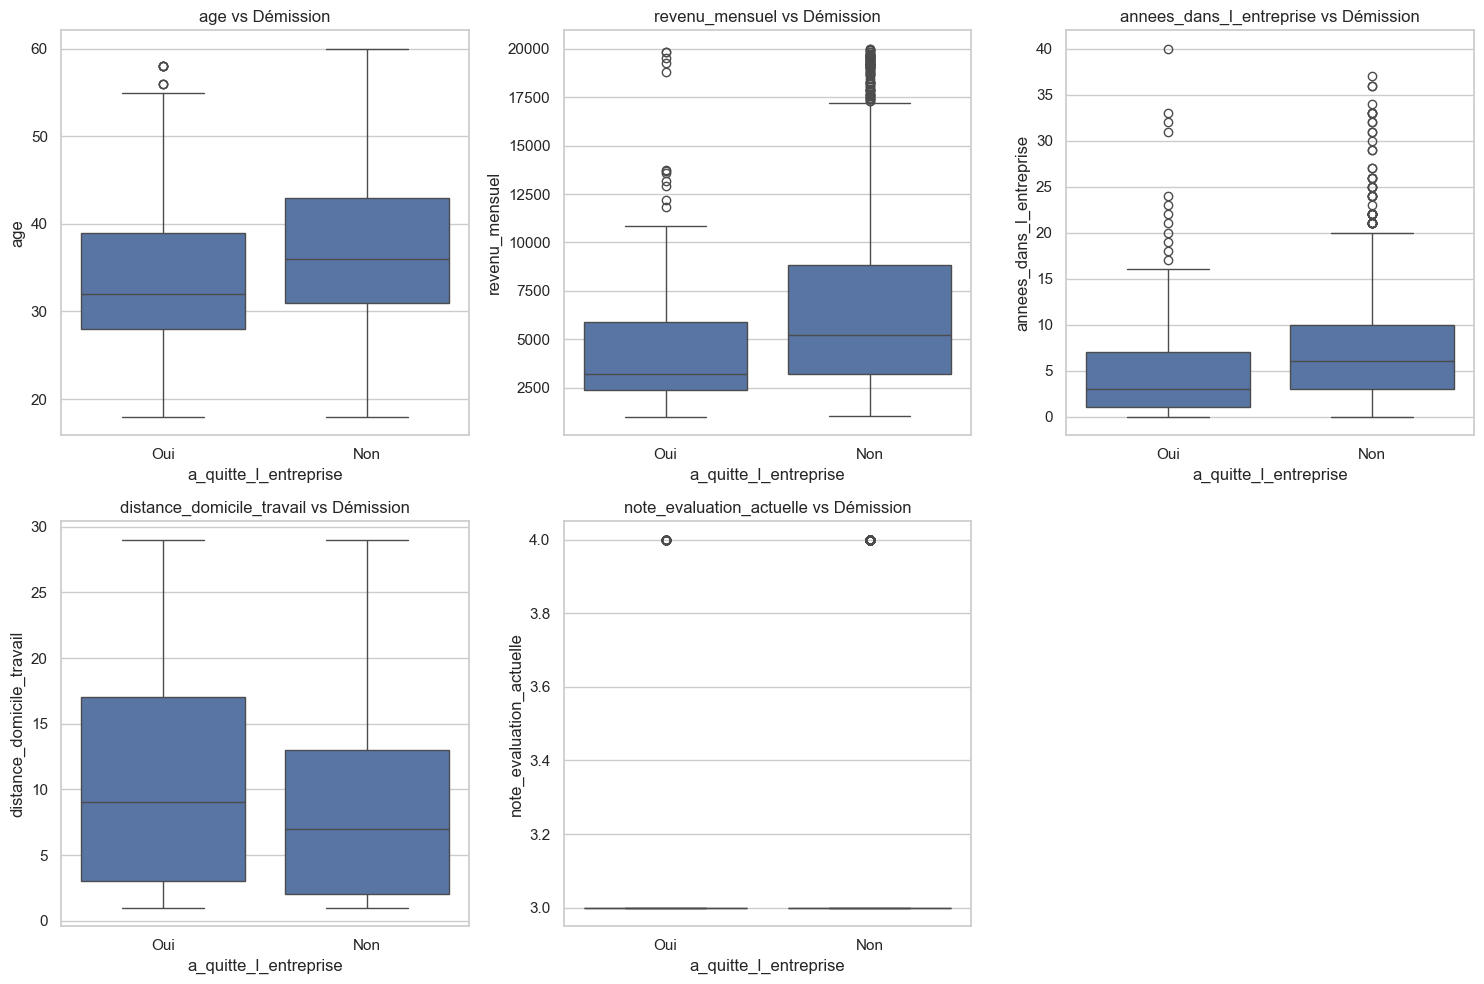

In [13]:
# Sélection de quelques variables clés pour l'analyse
key_num_cols = ['age', 'revenu_mensuel', 'annees_dans_l_entreprise', 'distance_domicile_travail', 'note_evaluation_actuelle']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_merged, x=target_col, y=col)
    plt.title(f"{col} vs Démission")
plt.tight_layout()
plt.show()

### 3.4 Analyse des variables catégorielles vs Démission

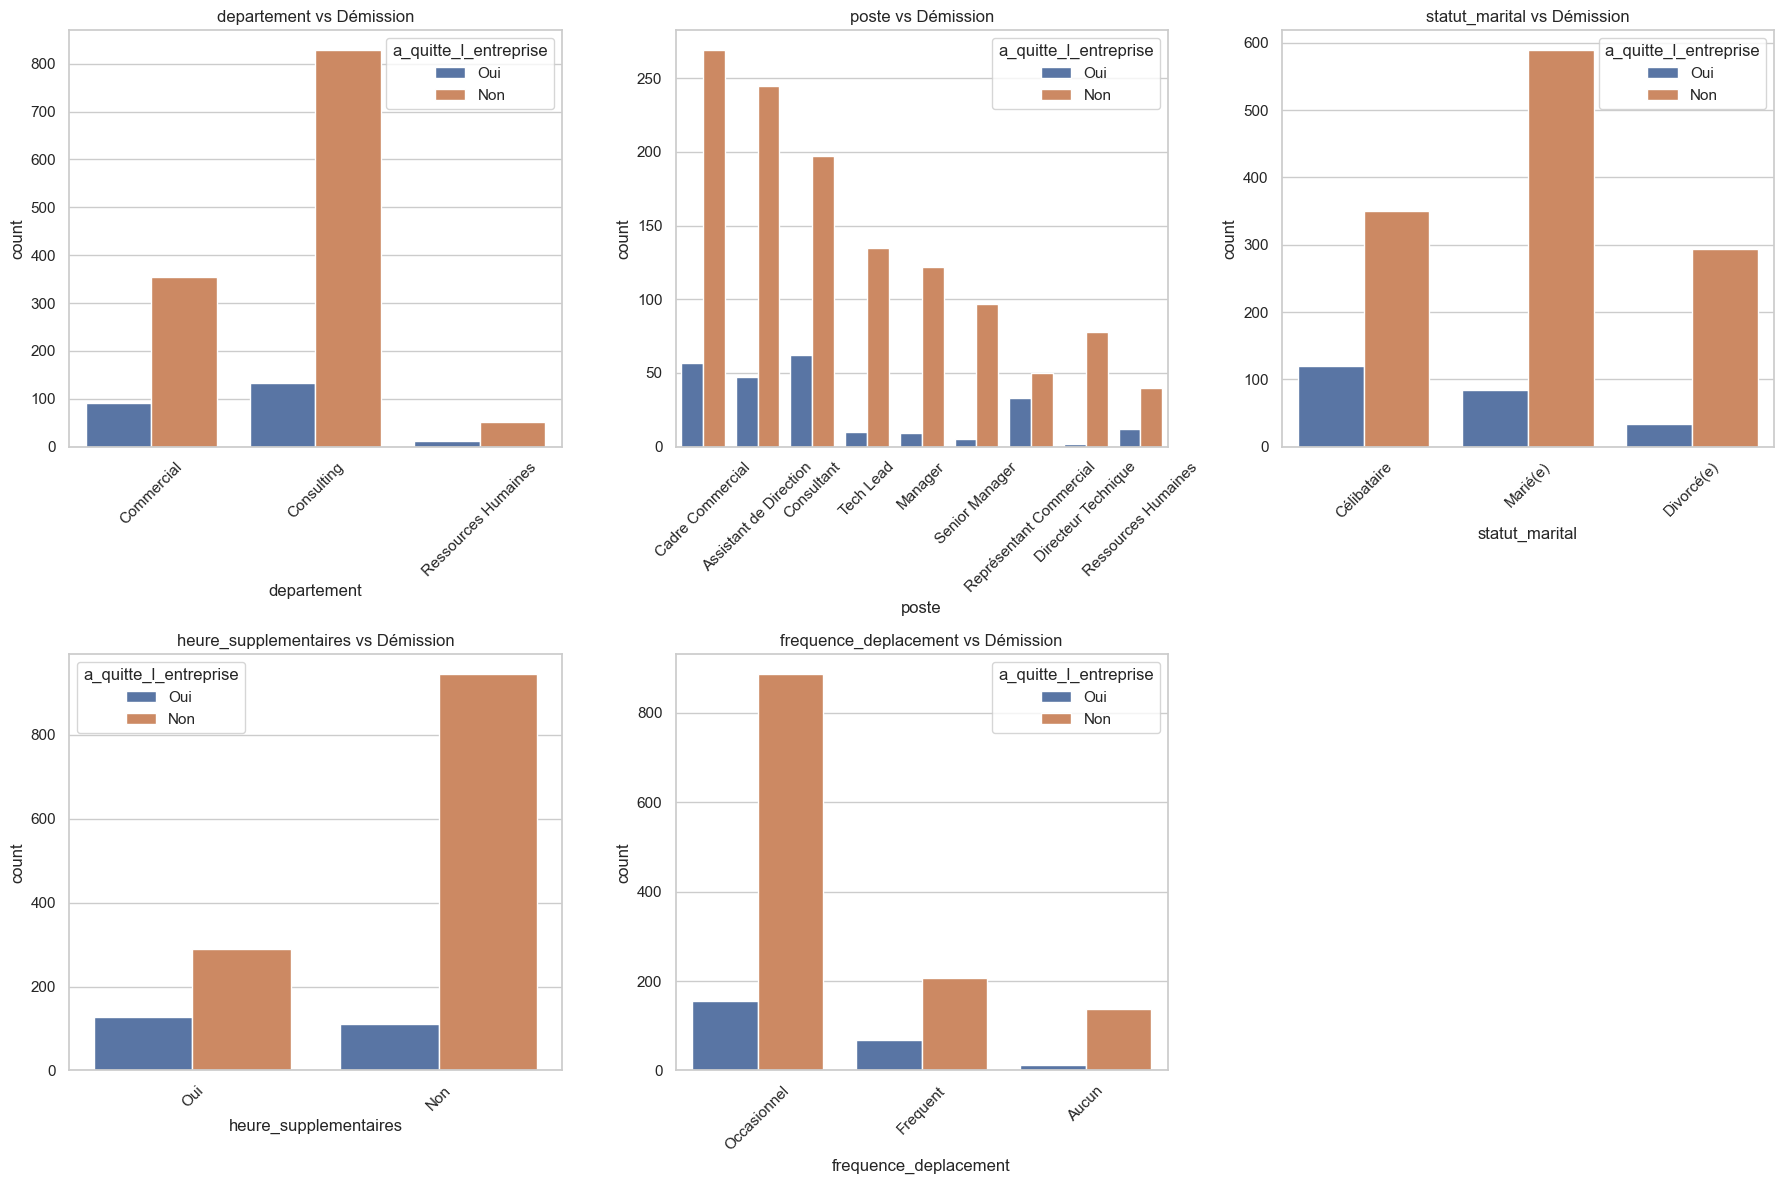

In [14]:
key_cat_cols = ['departement', 'poste', 'statut_marital', 'heure_supplementaires', 'frequence_deplacement']

plt.figure(figsize=(18, 12))
for i, col in enumerate(key_cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df_merged, x=col, hue=target_col)
    plt.title(f"{col} vs Démission")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.5 Analyse de la Satisfaction

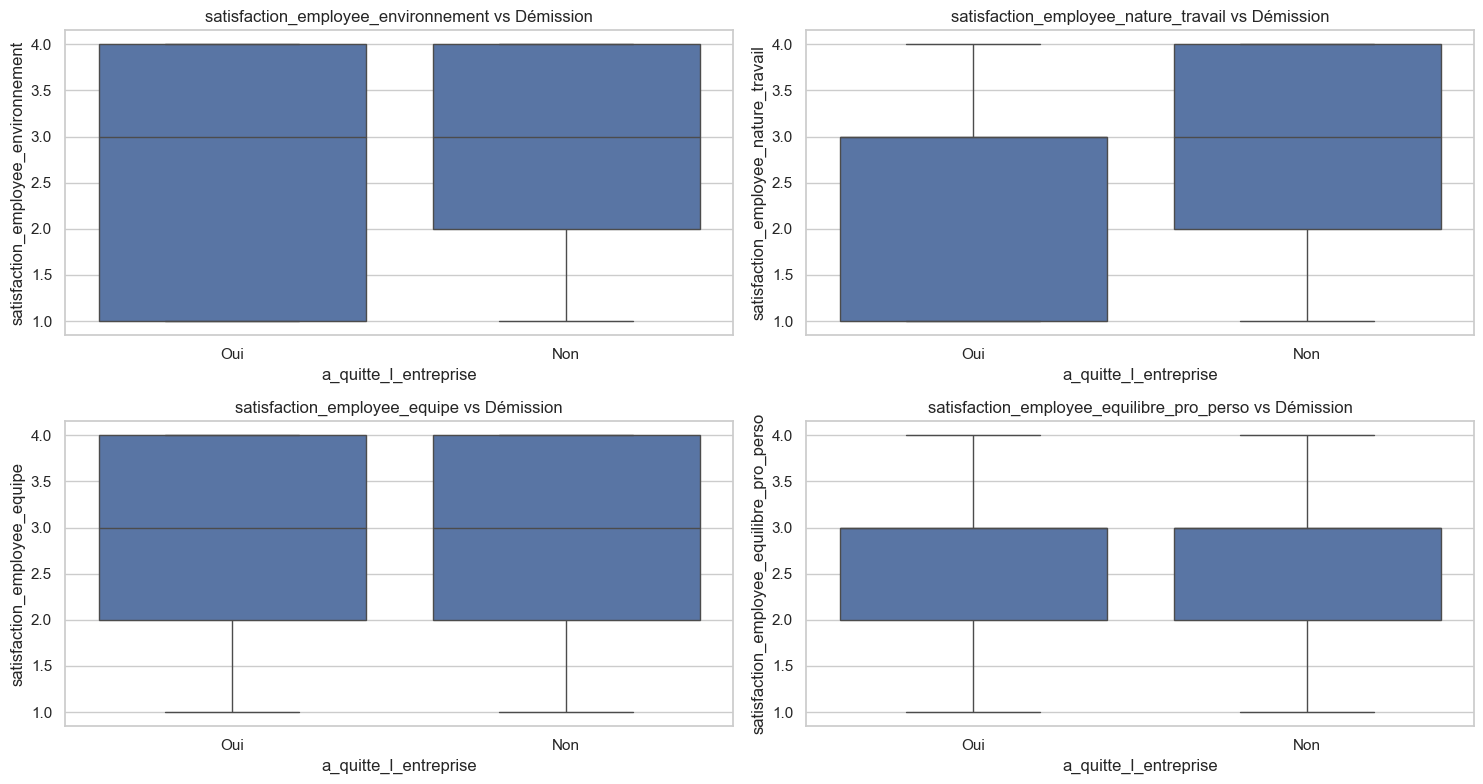

In [15]:
satisfaction_cols = [col for col in df_merged.columns if 'satisfaction' in col]

plt.figure(figsize=(15, 8))
for i, col in enumerate(satisfaction_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df_merged, x=target_col, y=col)
    plt.title(f"{col} vs Démission")
plt.tight_layout()
plt.show()